In [1]:
import sys
print(sys.executable)

/usr/bin/python3


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
#from wordclou import WordCloud
import re
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score

In [32]:
# import classifiers
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score

# Load the Dataset

In [4]:
df = pd.read_pickle("./sample_data/emoji_train.pkl")      # Shape: (42627, 4)
test = pd.read_pickle("./sample_data/emoji_test.pkl")        # (10657, 4)

df.head(4)

,tweet,emoji_class,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None


In [5]:
df = df.rename(columns={'emoji_class': 'label'})
df.head(4)

,tweet,label,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42627 entries, 0 to 42626
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            42627 non-null  object
 1   label            42627 non-null  int64 
 2   emoji            42627 non-null  object
 3   predicted_class  0 non-null      object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
None
shape of train dataset (42627, 4)
0    16846
1     7801
2     6103
3     4884
4     2450
5     2431
6     2112
Name: label, dtype: int64


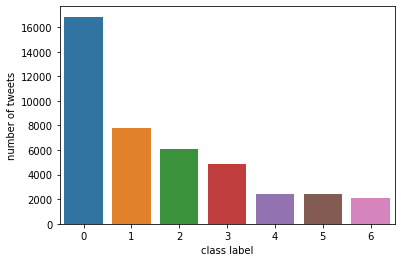

In [6]:
print(df.info())
print('shape of train dataset',df.shape)
print(df.label.value_counts())

sns.countplot(df.label,)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

In [ ]:
# plt.hist(df[df['label']==1].tweet.str.len(),bins=20,label='class 1')
# plt.legend()
# plt.xlabel('length of tweets')
# plt.ylabel('number of tweets')
# plt.show()
# plt.hist(df[df['label']==0].tweet.str.len(),color='yellow',bins=20,label='class 0')
# plt.legend()
# plt.xlabel('length of tweets')
# plt.ylabel('number of tweets')
# plt.show()

## Preprocessing Tweet Text
   1. Removing Twitter Handles (@user)
   2. Removing urls from text
   3. Removing Punctuations, Numbers, and Special Characters
   4. Convert the word to lowercase
   5. Remove Stopwords
   6. Stemming the word
   7. Lemmatization
After which we collect the words used to describe positive and negative reviews

In [7]:
text=df['tweet'].values.tolist()
text_test=test['tweet'].values.tolist()
text+=text_test
print(len(text))

53284


In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [9]:
stopword=nltk.corpus.stopwords.words('english')
stopword.remove('not')
for index,text_ in enumerate(text):
    text_=re.sub(r'@[\w]*','',text_) #Removing Twitter Handles (@user)
    text_=re.sub(r'http/S+','',text_) #Removing urls from text 
    text_=re.sub(r'[^A-Za-z#]',' ',text_) #Removing Punctuations, Numbers, and Special Characters
    text_=" ".join(i.lower() for i in text_.split() if i.lower() not in stopword) #Removing stopword
    text[index]=text_

In [10]:
# #Stemming the word
pt=PorterStemmer()
wordnet=WordNetLemmatizer()
for index,text_ in enumerate(text):
    text_=" ".join(pt.stem(i) for i in text_.split())
    text_=" ".join(wordnet.lemmatize(i) for i in text_.split())  
    text[index]=text_

In [11]:
df['preprocess_tweet']=text[:len(df)]
df['length_tweet']=df['preprocess_tweet'].str.len()
test['preprocess_tweet']=text[len(df):]
df.head()

,tweet,label,emoji,predicted_class,preprocess_tweet,length_tweet
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None,brought courtesi red white blue welcom home so...,51
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None,#taotuesday tao downtown,24
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None,readi celebr america happi #independenceday co...,57
3,10min project w old footage #houstonphotograph...,2,📸,None,min project w old footag #houstonphotograph #h...,73
4,Usually I don't put song on my insta but this ...,3,🔥,None,usual put song insta shit fire thank #aoifound...,57


# Featurization

## BOW

In [12]:
train=df.copy()
train.drop(columns=['tweet','label','predicted_class','preprocess_tweet'],inplace=True)

In [13]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(df['preprocess_tweet'])
bow_df=bow.transform(df['preprocess_tweet']).toarray()
print('feature name==',bow.get_feature_names()[:10])
print('number of uniqe words',bow_df.shape[1])
print('shape',bow_df.shape)
bow_train=pd.DataFrame(bow_df)
bow_train['length_tweet']=df['length_tweet']
bow_train['label']=df['label']
bow_train.head()

feature name== ['absolut', 'academi', 'act', 'actual', 'adventur', 'af', 'afternoon', 'ago', 'air', 'airport']
number of uniqe words 1000
shape (42627, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,57,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,73,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,57,3


## TF-IDF Features (Bi-Grams)

In [14]:
tfidf=TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000)
tfidf.fit(df['preprocess_tweet'])
tfidf_df=tfidf.transform(df['preprocess_tweet']).toarray()
print('number of uniqe words',bow_df.shape[1])
print('shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
tfidf_train['length_tweet']=df['length_tweet']
tfidf_train['label']=df['label']
tfidf_train.head()

number of uniqe words 1000
shape (42627, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,3


In [15]:
tokenize=df['preprocess_tweet'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['preprocess_tweet']),epochs=20)

(5865916, 6125420)

In [16]:
#w2v_words = list(w2vec_model.wv.vocab)
w2v_words = list(w2vec_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  51557
sample words  ['brought', 'courtesi', 'red', 'white', 'blue', 'welcom', 'home', 'soldier', '#taotuesday', 'tao', 'downtown', 'readi', 'celebr', 'america', 'happi', '#independenceday', 'columbia', 'cafe', 'min', 'project', 'w', 'old', 'footag', '#houstonphotograph', '#houstonvideograph', '#banksvisu', 'usual', 'put', 'song', 'insta', 'shit', 'fire', 'thank', '#aoifoundmeanewthang', 'toilet', 'talk', '#hillsidefestiv', '#positivevib', '#radiat', '#medit', '#life', '#journey', '#peac', '#artbaselmiami', 'exquisit', 'eye', 'south', 'beach', 'miami', 'firey']


In [17]:
vector=[]
from tqdm import tqdm
for sent in tqdm(tokenize):
  sent_vec=np.zeros(100)
  count =0
  for word in sent: 
    if word in w2v_words:
      vec = w2vec_model.wv[word]
      sent_vec += vec 
      count += 1
  if count != 0:
    sent_vec /= count #normalize
  vector.append(sent_vec)
print(len(vector))
print(len(vector[0]))    

100%|██████████| 42627/42627 [01:17<00:00, 547.08it/s]

42627
100


In [18]:
#example
l='father dysfunct selfish drag kid dysfunct'
count=0
vcc=np.zeros(100)
for word in l:
  if word in w2v_words:
    v=w2vec_model.wv[word]
    vcc+=v
    count+=1
vcc

array([ 4.61884959e+00, -2.14084309e+00, -7.94422044e+00, -1.55603623e+00,
        1.09481373e+01, -2.47392233e+00,  4.51904773e+00,  1.34482860e+00,
       -7.34344739e-01, -1.78375516e+00,  2.59779423e+00, -2.27646427e+00,
        3.41065943e+00,  4.06999036e+00, -4.19393365e+00, -6.13616041e+00,
        4.39110655e+00, -5.59499053e+00,  7.57956497e+00, -4.19016581e+00,
       -1.66789755e-01,  7.07663452e+00,  1.31933592e+01,  1.14328102e+01,
       -3.59121278e+00,  1.70903765e+01, -1.90580601e+00,  1.99968663e+01,
       -3.48884093e+00,  7.67811719e+00,  1.88819643e+01,  7.24386306e+00,
       -3.20432951e+01,  1.16971600e+00, -9.14187998e-01,  6.59432414e-02,
        1.67928636e+01, -1.64381210e+01, -1.58024428e+00,  5.32042613e+00,
       -2.24667387e+00,  2.27591701e+01,  1.02057731e+01,  1.50640391e+01,
       -9.49950788e+00,  4.00752097e+00, -2.00612168e+00,  7.84330018e+00,
        3.37342399e+00, -1.30621525e+01, -2.09471419e+01, -4.53390453e+00,
        4.87594349e+00, -

In [19]:
print('number of uniqe words',len(vector[1]))
w2v_train=pd.DataFrame(vector)
w2v_train['length_tweet']=df['length_tweet']
w2v_train['label']=df['label']
w2v_train.head()

number of uniqe words 100


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,length_tweet,label
0,0.484086,0.327169,0.262290,0.877388,0.458539,-0.192249,0.295623,-0.035565,0.028694,0.591286,...,-0.058664,0.254617,-0.360480,-0.036331,0.643420,-0.438188,-0.004155,0.108594,51,5
1,0.269409,-0.013137,-0.036568,0.161731,0.284221,-0.304558,0.139581,0.279220,-0.042903,-0.197992,...,-0.177367,-0.186501,-0.420238,0.433023,-0.006402,-0.093438,0.106431,0.038965,24,3
2,-0.145218,-0.202185,0.016587,0.400268,0.548937,0.036917,0.124754,0.352450,-0.048887,-0.213876,...,-0.193877,0.139105,-0.758091,0.054299,0.030758,-0.189760,0.005444,0.216887,57,5
3,0.127865,0.075960,-0.113565,0.496414,0.107669,0.117465,0.115292,0.096232,-0.009364,-0.083318,...,-0.328939,0.169576,-0.257969,0.163515,0.223181,-0.286481,0.211966,0.109127,73,2
4,0.406861,0.240424,-0.352208,0.230824,0.374962,-0.062146,0.352506,0.364667,-0.063466,0.045155,...,-0.503718,0.478595,-0.165628,0.226207,0.377119,-0.247933,0.225970,0.433938,57,3


# Resample

## Upsampling BOW

In [20]:
bow_train.label.value_counts()

0    16846
1     7801
2     6103
3     4884
4     2450
5     2431
6     2112
Name: label, dtype: int64

shape (117922, 1002)


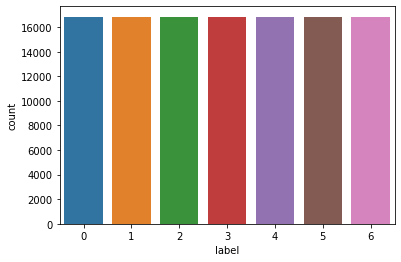

In [21]:
major_class_0,major_class_1, major_class_2, major_class_3, major_class_4, major_class_5, major_class_6 =bow_train.label.value_counts()
df_major0=bow_train[bow_train['label']==0]
df_major1=bow_train[bow_train['label']==1]
df_major2=bow_train[bow_train['label']==2]
df_major3=bow_train[bow_train['label']==3]
df_major4=bow_train[bow_train['label']==4]
df_major5=bow_train[bow_train['label']==5]
df_major6=bow_train[bow_train['label']==6]

df_minor1_upsampled = resample(df_major1, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor2_upsampled = resample(df_major2, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor3_upsampled = resample(df_major3, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor4_upsampled = resample(df_major4, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor5_upsampled = resample(df_major5, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor6_upsampled = resample(df_major6, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_bow_upsampled = pd.concat([df_major0, df_minor1_upsampled,df_minor2_upsampled, df_minor3_upsampled, df_minor4_upsampled, df_minor5_upsampled, df_minor6_upsampled])
print('shape',df_bow_upsampled.shape)
sns.countplot(df_bow_upsampled.label)

## Upsampling TF-IDF

shape (117922, 1002)


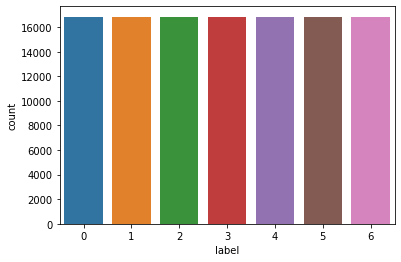

In [22]:
major_class_0,major_class_1, major_class_2, major_class_3, major_class_4, major_class_5, major_class_6=tfidf_train.label.value_counts()
df_major0=tfidf_train[tfidf_train['label']==0]
df_major1=tfidf_train[tfidf_train['label']==1]
df_major2=tfidf_train[tfidf_train['label']==2]
df_major3=tfidf_train[tfidf_train['label']==3]
df_major4=tfidf_train[tfidf_train['label']==4]
df_major5=tfidf_train[tfidf_train['label']==5]
df_major6=tfidf_train[tfidf_train['label']==6]

df_minor1_upsampled = resample(df_major1, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor2_upsampled = resample(df_major2, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor3_upsampled = resample(df_major3, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor4_upsampled = resample(df_major4, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor5_upsampled = resample(df_major5, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor6_upsampled = resample(df_major6, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_tfidf_upsampled  = pd.concat([df_major0, df_minor1_upsampled,df_minor2_upsampled, df_minor3_upsampled, df_minor4_upsampled, df_minor5_upsampled, df_minor6_upsampled])
print('shape',df_tfidf_upsampled.shape)
sns.countplot(df_tfidf_upsampled.label)

# Split Dataset

In [23]:
x=df_bow_upsampled.iloc[:,0:-1]
y=df_bow_upsampled['label']
x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(x,y,test_size=0.2)

In [24]:
x=df_tfidf_upsampled.iloc[:,0:-1]
y=df_tfidf_upsampled['label']
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x,y,test_size=0.2)

## Metrics of Performance

In [25]:
def f1_score_(y_proba, y_pred):
  y_true = y_proba[:,1] >= 0.3
  y_true = y_true.astype(np.int) 
  f1 = f1_score(y_true, y_pred, average='micro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return f1

In [26]:
def recall(y_true,y_pred):
  #y_true = y_true[:,1] >= 0.3
  y_true = y_true.astype(np.int) 
  recall_result = recall_score(y_true, y_pred, average='macro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return recall_result

In [31]:
def precision(y_true,y_pred):
  y_true = y_true.astype(np.int) 
  precision_result = precision_score(y_true, y_pred, average='macro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return precision_result

# Training

### KNeighborsClassifier

In [27]:
#use Bow
k=[3,5,7,11]
accuracy=[]

for i in tqdm(k):
  model=KNeighborsClassifier(n_neighbors=i)
  model.fit(x_train_bow,y_train_bow)
  y_pred=model.predict(x_test_bow)
  acc=accuracy_score(y_pred,y_test_bow)
  print('for k=',i,'Accuracy Score',acc)
  accuracy.append(acc)
  y_proba=model.predict_proba(x_test_bow)
  f1_scor=f1_score_(y_proba,y_test_bow)
  print('for k=',i,'f1 score ',f1_scor)
  recall_result = recall(y_pred,y_test_bow)
  print('for k=',i,'Accuracy Score',recall_result)


  0%|          | 0/4 [01:47<?, ?it/s]


KeyboardInterrupt: ignored

In [28]:
def train(model, optimizer, X_train, train_y, max_epoch):

  train_loss = []
  train_acc = []
  y_target =[]

  # Divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)     # Decays the learning rate of each parameter group by gamma every step_size epochs.                                                                            
  epoch = 0                                                                         # Epochs done so far
  stop = False   
  correct=0
  total=0

  loss_func =  nn.MSELoss()


  while epoch < max_epoch and not stop:                   
    running_loss = 0.0
    running_acc = 0.0

    optimizer.zero_grad()                                                          # Sets the gradients of all optimized torch.Tensors to zero

    yhat = model(X_train.float())                     # input x and predict based on 
    yhat = yhat.squeeze()
    loss = loss_func(yhat.to(torch.float32), train_y.to(torch.float32))
    loss.backward()                           # backward pass
    optimizer.step()                          # gradient descent; Performs a single optimization step (parameter update)                                                                               
      
    #Print the statistic
    running_loss += loss                                                
    #running_acc += loss
    epoch_loss = running_loss
    epoch_acc = running_acc
    print('Epoch {:d} -- Loss: {:.4f} '.format(epoch+1,epoch_loss))
    #print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()                                                                 # This change the learning rate at each epoch, otherwise the LR would stays at the initial value                                             
    train_loss.append(loss)
    #train_acc= np.append(train_acc,epoch_acc)
    #y_target.append(target_inds)
  return train_loss, train_acc 

In [ ]:
#use tfidf
k=[3,5,11]
accuracy_tfidf=[]
for i in k:
  model=KNeighborsClassifier(n_neighbors=i)
  model.fit(x_train_tfidf,y_train_tfidf)
  y_pred=model.predict(x_test_tfidf)
  acc=accuracy_score(y_pred,y_test_tfidf)
  print('for k=',i,'Accuracy Score',acc)
  accuracy_tfidf.append(acc)
  y_proba=model.predict_proba(x_test_tfidf)
  f1_scor=f1_score_(y_proba,y_test_tfidf)
  print('for k=',i,'f1 score ',f1_scor)
  print('for k=',i,'Recall',recall(y_pred,y_test_bow))
  print('Precision', precision_score(y_test_bow, y_pred, average='macro'))

for k= 3 Accuracy Score 0.768624125503498
for k= 3 f1 score  0.22382870468518126
for k= 3 Recall <function recall at 0x7f4df74d2440>
for k= 5 Accuracy Score 0.7143947424210303
for k= 5 f1 score  0.2129319482722069
for k= 5 Recall <function recall at 0x7f4df74d2440>


### DecisionTreeClassifier

In [55]:
#use tfidf
model = DecisionTreeClassifier()
model.fit(x_train_tfidf,y_train_tfidf)
y_pred=model.predict(x_test_tfidf)
acc=accuracy_score(y_pred,y_test_tfidf)
print('Accuracy Score',acc)

y_proba=model.predict_proba(x_test_tfidf)
print('f1 score ', f1_score_(y_proba,y_test_tfidf))
print('Recall', recall(y_pred,y_test_tfidf))
print('Precision', precision(y_test_tfidf, y_pred))

Accuracy Score 0.8746661013355946
f1 score  0.24757260970956116
Recall 0.872139218138079
Precision 0.872139218138079


In [57]:
#use Bow
model=DecisionTreeClassifier()
model.fit(x_train_bow,y_train_bow)
y_pred_bow=model.predict(x_test_bow)
acc=accuracy_score(y_pred_bow,y_test_bow)

print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_bow)
f1_scor=f1_score_(y_proba,y_test_bow)

print('f1 score ',f1_score_(y_proba,y_test_bow))
print('Recall', recall(y_pred_bow,y_test_bow))
print('Precision', precision(y_test_bow, y_pred_bow))

Accuracy Score 0.8750052999788
f1 score  0.24464702141191436
Recall 0.870981264629304
Precision 0.870981264629304


### Gaussian Naïve Bayes Classifier

In [33]:
#use tfidf
model = GaussianNB()
model.fit(x_train_tfidf,y_train_tfidf)
y_pred_tfidf=model.predict(x_test_tfidf)

acc=accuracy_score(y_pred_tfidf,y_test_tfidf)
print('Accuracy Score',acc)

y_proba=model.predict_proba(x_test_tfidf)

print('f1 score ', f1_score_(y_proba,y_test_tfidf))
print('Recall', recall(y_pred_tfidf,y_test_tfidf))
print('Precision', precision(y_test_tfidf, y_pred_tfidf))

Accuracy Score 0.45503497986008057
f1 score  0.17345770616917533
Recall 0.4876067519486349
Precision 0.4876067519486349


In [35]:
#use Bow
model=GaussianNB()
model.fit(x_train_bow,y_train_bow)
y_pred_bow=model.predict(x_test_bow)

acc=accuracy_score(y_pred_bow,y_test_bow)
print('Accuracy Score',acc)

y_proba=model.predict_proba(x_test_bow)
f1_scor=f1_score_(y_proba,y_test_bow)

print('f1 score ',f1_scor)
print('Recall', recall(y_pred_bow,y_test_bow))
print('Precision', precision(y_test_bow, y_pred_bow))

Accuracy Score 0.417935128259487
f1 score  0.16540173839304642
Recall 0.48878608017980435
Precision 0.48878608017980435
